*Большую часть NLP-специфичного материала (TF-IDF, BagOfWords, N-grams и т.д.) мы пропускаем. Если эти темы вам в дальнейшем понадобятся, могут быть полезны материалы*
- *Подробнее про эмбеддинги на примере word2vec: [хабр](https://habr.com/ru/articles/446530/)*
- *Серия лекций DLS МФТИ по NLP, начало тут: [вк](https://vk.com/video-155161349_456239178), [youtube](https://www.youtube.com/watch?v=StZaHBNWiOs)*
- *Серия видео 3Blue1Brown по LLM: [youtube](https://www.youtube.com/watch?v=LPZh9BOjkQs&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=5)*
- *Оригинальная работа, в которой введено внимание Баданау: [arxiv](https://arxiv.org/abs/1409.0473)*

*На этой лекции мы очень кратко рассмотрим токенизацию и эмбеддинги, реализуем простой текстовый классификатор на основе GRU-энкодера, а затем модифицируем его, реализовав механизм внимания Баданау.*

In [3]:
!pip install gensim
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import random
import math
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Зафиксируем зерна
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Используемое устройство: cuda


## 1. Токенизация и эмбеддинги

`gensim` - библотека для работы с текстом и темами, в области обработки естественного языка (NLP). В частности, она позволяет широкий функционал для векторизации текста, но этим функционал не ограничивается (см. https://pypi.org/project/gensim/)

In [5]:
import gensim.downloader as api

glove_vectors = api.load('glove-wiki-gigaword-50')
type(glove_vectors)
# https://radimrehurek.com/gensim/models/keyedvectors.html

[==================================================] 100.0% 66.0/66.0MB downloaded


gensim.models.keyedvectors.KeyedVectors

In [6]:
vec1 = glove_vectors['cat']
print(vec1)

[ 0.45281  -0.50108  -0.53714  -0.015697  0.22191   0.54602  -0.67301
 -0.6891    0.63493  -0.19726   0.33685   0.7735    0.90094   0.38488
  0.38367   0.2657   -0.08057   0.61089  -1.2894   -0.22313  -0.61578
  0.21697   0.35614   0.44499   0.60885  -1.1633   -1.1579    0.36118
  0.10466  -0.78325   1.4352    0.18629  -0.26112   0.83275  -0.23123
  0.32481   0.14485  -0.44552   0.33497  -0.95946  -0.097479  0.48138
 -0.43352   0.69455   0.91043  -0.28173   0.41637  -1.2609    0.71278
  0.23782 ]


In [7]:
glove_vectors

In [8]:
vec1 = - glove_vectors['men'] + glove_vectors['women']
vec2 = glove_vectors['boy']
glove_vectors.most_similar(vec1+vec2)

[('girl', 0.8908959627151489),
 ('boy', 0.8820723295211792),
 ('child', 0.8383355140686035),
 ('woman', 0.8371262550354004),
 ('mother', 0.8076115250587463),
 ('teen', 0.8051162958145142),
 ('baby', 0.8035256862640381),
 ('girls', 0.7841326594352722),
 ('teenage', 0.7809747457504272),
 ('her', 0.7736338973045349)]

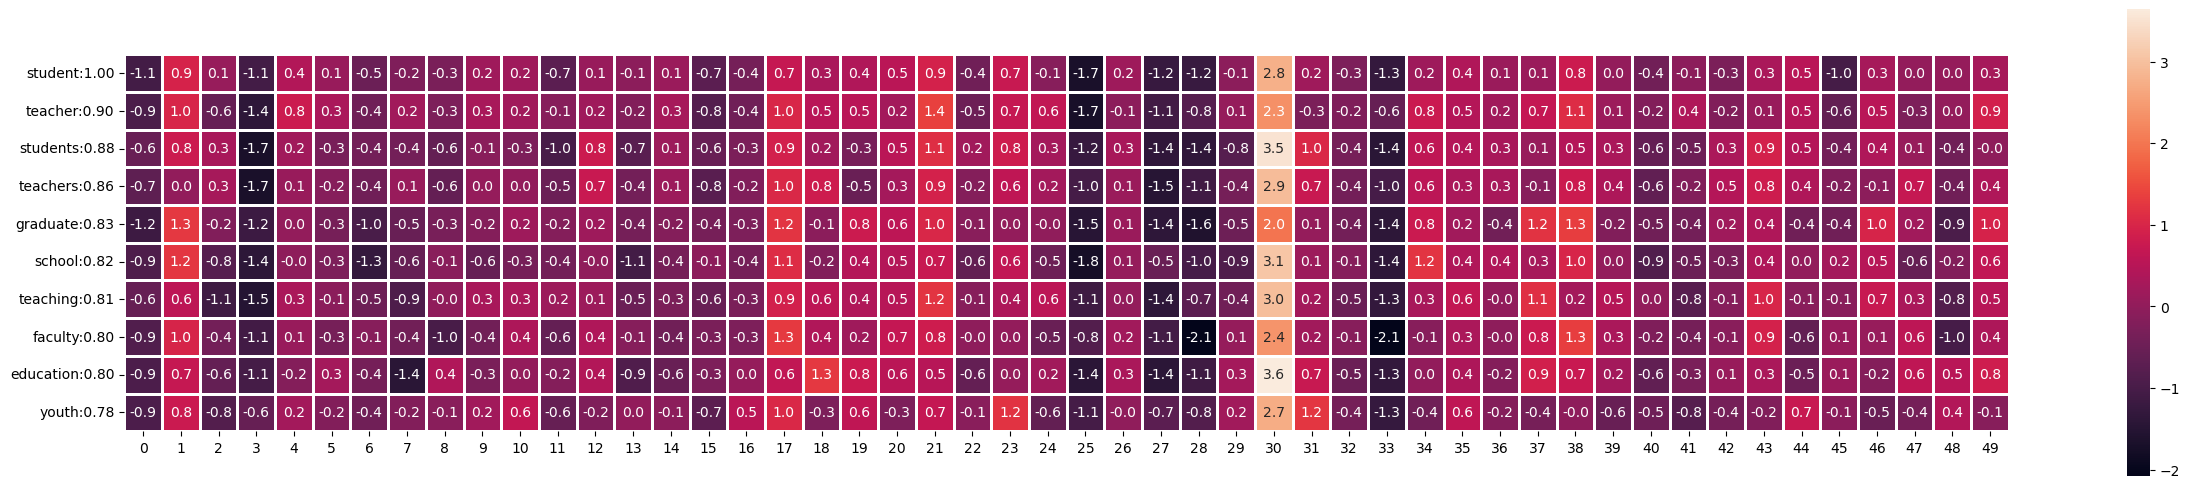

In [9]:
import seaborn as sns

vec = glove_vectors['student']
near = glove_vectors.most_similar(vec)
words = [val[0] for val in near]
cosine = [val[1] for val in near]
vecs = [glove_vectors[word] for word in words]
vecs = np.stack(vecs)

labels = [f'{w}:{float(s):.2f}' for w, s in zip(words, cosine)]
fig = plt.figure(figsize=(25, 5))
sns.heatmap(vecs, yticklabels=labels, annot=True, fmt=".1f", linewidths=1, square=True)

plt.tight_layout()
plt.show()

In [10]:
shift = np.zeros(50)
shift[29] = 3.0

glove_vectors.most_similar(glove_vectors['human'] + shift)

[('human', 0.8880319595336914),
 ('causes', 0.7168674468994141),
 ('environment', 0.6971821188926697),
 ('critical', 0.696492075920105),
 ('serious', 0.6924506425857544),
 ('nature', 0.690519392490387),
 ('cause', 0.6861452460289001),
 ('rights', 0.6844738125801086),
 ('intellectual', 0.6816993951797485),
 ('social', 0.6815671324729919)]

In [11]:
# Проблема: по умолчанию вектора для специальных символов отсутствуют.

special_keys = ['<pad>', '<bos>', '<eos>', '<unk>']

for key in special_keys:
    if key not in glove_vectors:
        print(f'{key} is not present')
    else:
        print(f'{key}: {glove_vectors[key]}')

<pad> is not present
<bos> is not present
<eos> is not present
<unk> is not present


In [12]:
PAD = '<pad>'
BOS = '<bos>'
EOS = '<eos>'
UNK = '<unk>'

special_vecs = {
        PAD: np.zeros((50,), dtype=np.float32),
        BOS: np.random.normal(size=(50,)).astype(np.float32),
        EOS: np.random.normal(size=(50,)).astype(np.float32),
        UNK: np.random.normal(size=(50,)).astype(np.float32),
}

glove_vectors.add_vectors([*special_vecs.keys()], [*special_vecs.values()])
glove_vectors.resize_vectors(seed=0)

for key in special_keys:
    print(glove_vectors.most_similar(key))

[('5,430', nan), ('termly', nan), ('mayen-koblenz', nan), ('chlorinate', nan), ('kalapana', nan), ('40.64', nan), ('hookey', nan), ('tigerman', nan), ('jagua', nan), ('kissane', nan)]
[('gtx', 0.5653982758522034), ('charcas', 0.5652481913566589), ('commendations', 0.5559910535812378), ('samjhota', 0.5545271635055542), ('leros', 0.5499374270439148), ('jiangling', 0.5493506789207458), ('killiecrankie', 0.5437741875648499), ('koysanjak', 0.54298996925354), ('intermediacy', 0.5425061583518982), ('jaune', 0.5409624576568604)]
[('lidl', 0.510595977306366), ('walgreens', 0.5095826983451843), ('wal-mart', 0.5059213638305664), ("dunkin'", 0.5034161806106567), ('qvc', 0.5004485249519348), ('karan', 0.49786603450775146), ('costco', 0.4896162152290344), ('warnaco', 0.4775121808052063), ('stubhub', 0.4770464301109314), ('barneys', 0.47661176323890686)]
[('palsied', 0.5854526162147522), ('mult', 0.5843150019645691), ('llywarch', 0.5819416642189026), ('jigging', 0.5760185718536377), ('grima', 0.56817

/home/student/miniconda3/envs/nn_env/lib/python3.12/site-packages/gensim/models/keyedvectors.py:449: RuntimeWarning: invalid value encountered in divide
  result = self.vectors[index] / self.norms[index]
/home/student/miniconda3/envs/nn_env/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


In [13]:
from gensim.models import KeyedVectors

class Tokenizer():

    PAD = '<pad>'
    BOS = '<bos>'
    EOS = '<eos>'
    UNK = '<unk>'
    special = [PAD, BOS, EOS, UNK]

    def __init__(self, vectors: KeyedVectors, preprocessor = None):

        for key in self.special:
            if key not in glove_vectors:
                raise ValueError(f'Cannot instantiate: special token {key} is not present in given embedding')
        self.vectors = vectors
        self.preprocessor = preprocessor

        self.PAD_idx = self.vectors.key_to_index[self.PAD]
        self.PAD_v = self.vectors[self.PAD_idx]
        self.BOS_idx = self.vectors.key_to_index[self.BOS]
        self.BOS_v = self.vectors[self.BOS_idx]
        self.EOS_idx = self.vectors.key_to_index[self.EOS]
        self.EOS_v = self.vectors[self.EOS_idx]
        self.UNK_idx = self.vectors.key_to_index[self.UNK]
        self.UNK_v = self.vectors[self.UNK_idx]

    def tokenize(self, text: str, preprocess=False):
        """Converts a string to a list of token indices, adding BOS and EOS tokens."""
        if preprocess:
            text = self.preprocessor(text)
        tokens = [self.BOS_idx]
        # Handle empty words that can result from split
        words = [word for word in text.split(' ') if word]
        tokens.extend(
            self.vectors.key_to_index.get(word, self.UNK_idx)
            for word in words
        )
        tokens.append(self.EOS_idx)
        return tokens

    def detokenize(self, idxs: list):

        return ''.join([self.vectors.index_to_key[i]+' ' for i in idxs]).strip()

In [14]:
tokenizer = Tokenizer(glove_vectors)

In [15]:
text = 'abra cadabra'
seq = tokenizer.tokenize(text)
print(seq)
print(tokenizer.detokenize(seq))


[400001, 75578, 400003, 400002]
<bos> abra <unk> <eos>


In [16]:
text = 'NLP (Neuro-Linguistic Programming) is a psychological approach that involves analyzing the patterns of thought, language, and behavior to understand how they interact with and influence human experience. There is no scientific evidence supporting the effectiveness of NLP; it is recognized as a pseudoscience.'
seq = tokenizer.tokenize(text)
print(seq)
print(tokenizer.detokenize(seq))

[400001, 400003, 400003, 400003, 14, 7, 5607, 1587, 12, 4959, 14337, 0, 6093, 3, 400003, 400003, 5, 2960, 4, 1906, 197, 39, 12574, 17, 5, 1729, 473, 400003, 400003, 14, 84, 2440, 906, 2534, 0, 8305, 3, 400003, 20, 14, 2861, 19, 7, 400003, 400002]
<bos> <unk> <unk> <unk> is a psychological approach that involves analyzing the patterns of <unk> <unk> and behavior to understand how they interact with and influence human <unk> <unk> is no scientific evidence supporting the effectiveness of <unk> it is recognized as a <unk> <eos>


In [17]:
text = 'General Relativity is a physical theory, which explains gravity as purely geometrical effect: curved spacetime tells matter how to move, while matter influences the curvature of spacetime'
seq = tokenizer.tokenize(text)
print(seq)
print(tokenizer.detokenize(seq))

[400001, 400003, 400003, 14, 7, 2183, 400003, 42, 5807, 9023, 19, 8850, 45242, 400003, 16566, 45381, 2969, 1120, 197, 4, 400003, 110, 1120, 7658, 0, 31153, 3, 45381, 400002]
<bos> <unk> <unk> is a physical <unk> which explains gravity as purely geometrical <unk> curved spacetime tells matter how to <unk> while matter influences the curvature of spacetime <eos>


In [18]:
import re
from string import punctuation

def text_cleanup(text: str):
    text = text.lower()
    # Удаляем двойные знаки препинания
    text = re.sub(r'([,.])\1+', r'\1', text)
    # Окружаем знаки препинания пробелами
    text = re.sub(f'([{punctuation}])', r' \1 ', text)
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

text_cleanup('sample text: with commas,  double  spaces  ([[and brackets]])..!')

'sample text : with commas , double spaces ( [ [ and brackets ] ] ) . !'

In [19]:
tokenizer.preprocessor = text_cleanup
text = 'General Relativity is a physical theory, which explains gravity as purely geometrical effect: curved spacetime tells matter how to move, while matter influences the curvature of spacetime'
seq = tokenizer.tokenize(text, preprocess=True)
print(seq)
print(tokenizer.detokenize(seq))

[400001, 216, 22651, 14, 7, 2183, 2314, 1, 42, 5807, 9023, 19, 8850, 45242, 1261, 45, 16566, 45381, 2969, 1120, 197, 4, 483, 1, 110, 1120, 7658, 0, 31153, 3, 45381, 400002]
<bos> general relativity is a physical theory , which explains gravity as purely geometrical effect : curved spacetime tells matter how to move , while matter influences the curvature of spacetime <eos>


## 2. Загрузка и предобработка данных

In [20]:
!mkdir ./data
!curl -L -o ./data/recipes-dataset-64k-dishes.zip\
  https://www.kaggle.com/api/v1/datasets/download/prashantsingh001/recipes-dataset-64k-dishes
!unzip ./data/recipes-dataset-64k-dishes.zip -d ./data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 39.8M  100 39.8M    0     0  2684k      0  0:00:15  0:00:15 --:--:-- 2708k
Archive:  ./data/recipes-dataset-64k-dishes.zip
  inflating: ./data/1_Recipe_csv.csv  
  inflating: ./data/2_Recipe_json.json  


In [21]:
import pandas as pd

# В общем случае не очень хорошо
data_path = './data/1_Recipe_csv.csv'
dataframe = pd.read_csv(data_path)
dataframe = dataframe.dropna().reset_index(drop=True)


In [22]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62126 entries, 0 to 62125
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     62126 non-null  object
 1   category         62126 non-null  object
 2   subcategory      62126 non-null  object
 3   description      62126 non-null  object
 4   ingredients      62126 non-null  object
 5   directions       62126 non-null  object
 6   num_ingredients  62126 non-null  int64 
 7   num_steps        62126 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


In [23]:
dataframe.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a b...","[""3/4 cup ketchup"", ""1/2 cup beer"", ""1 tablesp...","[""Combine ketchup, beer, Worcestershire sauce,...",9,5
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,These gochujang pork belly bites are sweet and...,"[""1 pound pork belly"", ""1/4 cup gochujang"", ""2...","[""Preheat an air fryer to 400 degrees F (200 d...",5,4
2,3-Ingredient Air Fryer Everything Bagel Chicke...,Air Fryer Recipes,Air Fryer Recipes,These 3-ingredient air fryer everything bagel ...,"[""1 \u00bc pounds chicken tenders"", ""1 tablesp...","[""Gather all ingredients. Preheat an air fryer...",3,4
3,Air Fryer Everything Bagel Chicken Cutlets,Air Fryer Recipes,Air Fryer Recipes,These air fryer everything bagel chicken cutle...,"[""4 chicken cutlets (about 1 pound total)"", ""s...","[""Preheat an air fryer to 400 degrees F (200 d...",9,9
4,Air Fryer Honey Sriracha Salmon Bites,Air Fryer Recipes,Air Fryer Recipes,These air fryer honey Sriracha salmon bites ar...,"[""1 tablespoon soy sauce"", ""1 tablespoon honey...","[""Preheat an air fryer to 400 degrees F (200 d...",5,5


In [24]:
dataframe['category'].unique()

array(['Air Fryer Recipes', 'Allrecipes Allstar Recipes',
       'Angel Food Cakes', 'Antipasti', 'Appetizers And Snacks',
       'Apple Pie', 'Applesauce', 'Artichoke Dips', 'Bagels',
       'Baked Beans', 'Banana Breads', 'Bar Cookies', 'Beef Recipes',
       'Beef Stews', 'Beef Stroganoff', 'Beef Tenderloin', 'Biscotti',
       'Biscuits', 'Blintzes', 'Blondies', 'Bloody Marys',
       'Blueberry Pie', 'Borscht', 'Breads', 'Breakfast And Brunch',
       'Breakfast Burritos', 'Breakfast Casseroles', 'Breakfast Potatoes',
       'Breakfast Stratas', 'Brines', 'Broccoli Salads', 'Brownies',
       'Bruschetta', 'Buffalo Chicken Dips', 'Buffalo Chicken Wings',
       'Bulgogi', 'Burgers', 'Burritos', 'Butternut Squash Soups',
       'Cabbage Rolls', 'Cakes', 'Calzones', 'Camping Recipes',
       'Canning And Preserving', 'Carrot Cakes', 'Casseroles', 'Ceviche',
       'Cheese Balls', 'Cheese Fondue', 'Cheesecakes', 'Chef John',
       'Cherry Pie', 'Chess Pie', 'Chicken Adobo',
       '

In [25]:
NCLASSES = 16
most_commons = dataframe['category'].value_counts()[:NCLASSES]
categories = list(most_commons.index)
most_commons

category
Main Dishes              3387
Healthy Recipes          2237
Appetizers And Snacks    2084
Cakes                    1954
Cookies                  1849
Beef Recipes             1400
Breads                   1352
Desserts                 1288
Breakfast And Brunch     1223
Pork                     1205
Mexican                  1069
Christmas                1020
Vegetarian                968
Pies                      954
Christmas Cookies         945
Casseroles                941
Name: count, dtype: int64

In [26]:
df_reduced = dataframe[dataframe['category'].isin(categories)]

In [27]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23876 entries, 936 to 60700
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     23876 non-null  object
 1   category         23876 non-null  object
 2   subcategory      23876 non-null  object
 3   description      23876 non-null  object
 4   ingredients      23876 non-null  object
 5   directions       23876 non-null  object
 6   num_ingredients  23876 non-null  int64 
 7   num_steps        23876 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.6+ MB


In [28]:
import re
import string

def process_recipe(row: pd.Series, columns_to_use: list[str]):
    """
    Processes a single recipe row from the DataFrame into a clean string.
    """
    entry_parts = []
    for col in columns_to_use:
        if col in row and pd.notna(row[col]):
            content = str(row[col])
            if isinstance(content, str) and content.startswith('[') and content.endswith(']'):
                content = re.sub(r'["\\\[\\\\\]]', '', content)
            entry_parts.append(f'{col.replace("_", " ")}: {content}')
            entry_parts.append(' ')

    return ''.join(entry_parts)

In [29]:
COLUMNS = [
    'recipe_title',
    'description',
    'ingredients',
    # 'directions'
    ]

process_recipe(dataframe.iloc[0], COLUMNS)

"recipe title: Air Fryer Potato Slices with Dipping Sauce description: These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food somewhere between a French fry and a potato chip. Do take the time to make the dipping sauce—it's worth it. ingredients: 3/4 cup ketchup, 1/2 cup beer, 1 tablespoon Worcestershire sauce, 1/2 teaspoon onion powder, 1/4 teaspoon cayenne, 2 baking potatoes, olive oil cooking spray, 1/2 teaspoon garlic powder, salt and freshly ground black pepper "

In [30]:
seq = tokenizer.tokenize(process_recipe(dataframe.iloc[0], COLUMNS), preprocess=True)
print(seq)
print(tokenizer.detokenize(seq))

[400001, 7232, 698, 45, 325, 49267, 10425, 13649, 17, 19104, 6892, 3925, 45, 158, 325, 49267, 10425, 13649, 1, 724, 17, 7, 4178, 31156, 19104, 6892, 1, 32, 7, 25109, 6474, 565, 5530, 118, 7, 348, 12880, 5, 7, 10425, 3860, 2, 88, 190, 0, 79, 4, 159, 0, 19104, 400003, 57, 1534, 1089, 20, 2, 7046, 45, 314, 274, 409, 366, 31156, 1, 176, 274, 232, 366, 4178, 1, 176, 13135, 20132, 6892, 1, 176, 274, 232, 9046, 10952, 5598, 1, 176, 274, 409, 9046, 31244, 1, 232, 10057, 9477, 1, 6952, 316, 5015, 10065, 1, 176, 274, 232, 9046, 9005, 5598, 1, 2982, 5, 13566, 817, 521, 5906, 400002]
<bos> recipe title : air fryer potato slices with dipping sauce description : these air fryer potato slices , served with a beer ketchup dipping sauce , are a tasty finger food somewhere between a french fry and a potato chip . do take the time to make the dipping <unk> ' s worth it . ingredients : 3 / 4 cup ketchup , 1 / 2 cup beer , 1 tablespoon worcestershire sauce , 1 / 2 teaspoon onion powder , 1 / 4 teaspoon cay

## 3. Контейнеры данных

In [31]:
from typing import List, Tuple

Inpt = List
'''Input vector'''
Tgt = List | torch.Tensor
'''Output vector (can take a form of List or torch.Tensor)'''

class RecipeDataset(Dataset):

    def __init__(self, df, columns, cat_vec, tokenizer, device='cpu', max_len=256):

        self.data_: List[Inpt] = []
        self.tgt_: List[Tgt] = []
        self.columns = columns
        self.tokenizer = tokenizer
        self.device = device
        self.PAD_idx = (tokenizer.PAD_idx)
        self.max_len = max_len
        self.idtype: torch.dtype = torch.int32
        self.fdtype: torch.dtype = torch.float32

        for i, row in df.iterrows():
            entry = process_recipe(row, columns)
            tokenized_recipe = tokenizer.tokenize(entry, preprocess=True)

            if len(tokenized_recipe) > 10:
                self.tgt_.append(cat_vec[i].tolist())
                self.data_.append(tokenized_recipe)

        self.size = len(self.data_)
        # self.subsample()

    def __len__(self):
        return self.size

    def __getitem__(self, idx) -> Tuple[Inpt, Tgt]:
        return self.data_[idx], self.tgt_[idx]

    # def subsample(self, last_idx=None, stride=1):
    #     if last_idx == None:
    #       last_idx = self.max_size
    #     else:
    #       last_idx = min(last_idx, self.max_size)

    #     self.data = self.data_[:last_idx:stride]
    #     self.tgt = self.data_[:last_idx:stride]
    #     self.size = len(self.data)

    def collate_fn(self, batch: List[Tuple[Inpt, Tgt]]):
        seq_lenghts = [len(x[0]) for x in batch]
        new_len = min(max(seq_lenghts), self.max_len)

        new_inp = []
        for i, seq_len in enumerate(seq_lenghts):
            _inp_ = batch[i][0][:new_len]
            if seq_len < new_len:
                _inp_.extend([self.PAD_idx]*(new_len - seq_len))
            new_inp.append(_inp_)

        # Для RNN размерность входа выбирают (seq_len, batch_size ...)
        # либо (batch_size, seq_len, ...). Будем использовать второй вариант.
        new_inp = torch.tensor(new_inp, dtype=self.idtype, device=self.device)
        new_tgt = torch.tensor([v[1] for v in batch], dtype=self.fdtype, device=self.device)

        return (new_inp, new_tgt)

In [32]:
from sklearn.preprocessing import OneHotEncoder

def get_dataloaders(df, columns_to_use, tokenizer, batch_size=1):
  """
  Loads data, splits it, and creates train, validation, and test DataLoaders.
  """
  cat_encoder = OneHotEncoder(sparse_output=False)
  cat_vec = cat_encoder.fit_transform(df[['category']])
  indices = list(range(len(df)))
  print(len(cat_vec))
  random.shuffle(indices)

  train_ratio = 0.8
  val_ratio = 0.1

  train_end = int(len(indices) * train_ratio)
  val_end = int(len(indices) * (train_ratio + val_ratio))

  train_indices = indices[:train_end]
  val_indices = indices[train_end:val_end]
  test_indices = indices[val_end:]

  train_df = df.iloc[train_indices].reset_index(drop=True)
  val_df = df.iloc[val_indices].reset_index(drop=True)
  test_df = df.iloc[test_indices].reset_index(drop=True)


  print(f"Data split:")
  print(f"Training set size: {len(train_df)}")
  print(f"Validation set size: {len(val_df)}")
  print(f"Test set size: {len(test_df)}")

  train_dataset = RecipeDataset(train_df, columns_to_use, cat_vec[train_indices], tokenizer)
  val_dataset = RecipeDataset(val_df, columns_to_use, cat_vec[val_indices], tokenizer)
  test_dataset = RecipeDataset(test_df, columns_to_use, cat_vec[test_indices], tokenizer)

  print(f"Number of samples:")
  print(f"Training: {len(train_dataset)}")
  print(f"Validation: {len(val_dataset)}")
  print(f"Test: {len(test_dataset)}")


  if batch_size >= 1:
      print("Using batching with padding. Ensure your training loop can handle batched data!")

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=train_dataset.collate_fn
                            )

  val_loader = DataLoader(val_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          collate_fn=val_dataset.collate_fn
                          )

  test_loader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                           collate_fn=test_dataset.collate_fn
                            )

  print(f"DataLoaders created with batch size {batch_size}.")

  return train_loader, val_loader, test_loader, cat_encoder
df = df_reduced.sample(1600, random_state=42)
train_loader, val_loader, test_loader, cat_encoder = get_dataloaders(df, COLUMNS, tokenizer, batch_size=8)

1600
Data split:
Training set size: 1280
Validation set size: 160
Test set size: 160
Number of samples:
Training: 1280
Validation: 160
Test: 160
Using batching with padding. Ensure your training loop can handle batched data!
DataLoaders created with batch size 8.


## 4. Классификация текста

In [33]:
import os
from typing import Iterable

class logger:
    active = False
    _calls_ = {}
    log_file = "logger_output.txt"  # Default log file path
    silent = True

    @classmethod
    def on(cls): cls.active = True

    @classmethod
    def off(cls): cls.active = False

    @classmethod
    def silent(cls, silent: bool = True):
        cls.silent = silent

    @classmethod
    def zero(cls):
        cls._calls_ = {}

    @classmethod
    def clear_log(cls):
        with open(cls.log_file, 'w') as f:
            f.write("")

    @classmethod
    def write_log(cls, msg):
        with open(cls.log_file, 'a') as f:
            f.write(msg + "\n")

    @classmethod
    def trace(cls, name):
        def log_fn(func):
            def wrapper(*args, **kwargs):
                if cls.active:
                    if name not in cls._calls_:
                        cls._calls_[name] = 0
                    msg = f'>>> {name} call {cls._calls_[name]}: \n Args: \n'
                    for i, arg in enumerate(args):
                        if isinstance(arg, torch.Tensor):
                            msg += f'\t arg[{i}]: shape={arg.shape}, dtype={arg.dtype}, device={arg.device}\n {arg} \n'
                        else:
                            msg += f'\t arg[{i}]: {arg}\n'

                    for k, arg in kwargs.items():
                        if isinstance(arg, torch.Tensor):
                            msg += f'\t kwarg[{k}]: shape={arg.shape}, dtype={arg.dtype}, device={arg.device}\n {arg} \n'
                        else:
                            msg += f'\t kwarg[{k}]: {arg} \n'

                    if not cls.silent: print(msg)
                    cls.write_log(msg)

                result = func(*args, **kwargs)

                if cls.active:
                    msg = f'Result: \n'
                    if isinstance(result, Iterable):
                        for i, outp in enumerate(result):
                            if isinstance(outp, torch.Tensor):
                                msg += f'\t output[{i}]: shape={outp.shape}, dtype={outp.dtype}, device={outp.device}\n {outp} \n'
                            else:
                                msg += f'\t output[{i}]: {outp}\n'
                    elif isinstance(result, torch.Tensor):
                        msg = f'\t output: shape={result.shape}, dtype={result.dtype}, device={result.device}\n {result} \n'
                    else:
                        msg += f'\t output: {result}\n'

                    if not cls.silent: print(msg)
                    cls.write_log(msg)
                    cls._calls_[name] += 1

                return result
            return wrapper

        return log_fn

In [34]:
embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(glove_vectors.vectors),
            freeze=True
            )

In [35]:
import torch.nn.functional as F

class Encoder(nn.Module):
    """
    Encoder module: Embedding + GRU. Returns outputs and hidden state.
    """
    def __init__(self, embedding, hidden_size, n_layers=1, dropout=0.5, bidirectional=True, freeze_emb=True):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = embedding
        self.rnn = nn.GRU(
            embedding.embedding_dim,
            hidden_size,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
            )

        self.dropout = nn.Dropout(dropout)
        self.max_len = 256

    @logger.trace('ENC')
    def forward(self, text, text_lengths = None):
        if text_lengths is None:
            text_lengths = [len(t) for t in text]
        X = self.dropout(self.embedding(text))
        X_packed = nn.utils.rnn.pack_padded_sequence(X, text_lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(X_packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        return output, hidden


In [36]:
class TextClassifier(nn.Module):
    """
    A text classification model without an attention mechanism, using Encoder.
    """
    def __init__(self, embedding, hidden_size, num_classes, n_layers=1, dropout=0.5, bidirectional=True):
        super().__init__()

        self.encoder = Encoder(embedding, hidden_size, n_layers, dropout, bidirectional)
        linear_input_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(linear_input_size, num_classes)
        self.bidirectional = bidirectional

    @logger.trace('CLSF')
    def forward(self, text, text_lengths = None):

        _, hidden = self.encoder(text, text_lengths)
        if self.bidirectional:
            hidden = torch.cat((hidden[-2, :,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        return F.softmax(self.fc(hidden), dim=1)


In [37]:
import torchinfo
# Гиперпараметры моделей
HIDDEN_SIZE = 50
N_LAYERS = 1
DROPOUT = 0.2

modelA = TextClassifier(embedding, HIDDEN_SIZE, NCLASSES, N_LAYERS, DROPOUT)
torchinfo.summary(modelA)

Layer (type:depth-idx)                   Param #
TextClassifier                           --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    (20,000,200)
│    └─GRU: 2-2                          30,600
│    └─Dropout: 2-3                      --
├─Linear: 1-2                            1,616
Total params: 20,032,416
Trainable params: 32,216
Non-trainable params: 20,000,200

In [38]:
# Пример входных данных
sample_text = ["this is a test recipe"]
tokenized = [tokenizer.tokenize(sample, preprocess=True) for sample in sample_text]
input_tensor = torch.tensor(tokenized, dtype=torch.long)  # (batch, seq_len)
text_lengths = torch.tensor([len(seq) for seq in tokenized], dtype=torch.long)  # (batch,)

# Вызов модели
modelA.eval()
logger.clear_log()
logger.on()
with torch.no_grad():
    y_pred = modelA(input_tensor, text_lengths)
    print(y_pred)
    print(f"Predicted class: {cat_encoder.inverse_transform(y_pred)}" )
logger.off()

tensor([[0.0504, 0.0496, 0.0636, 0.0715, 0.0689, 0.0808, 0.0612, 0.0522, 0.0695,
         0.0550, 0.0572, 0.0728, 0.0708, 0.0525, 0.0520, 0.0720]])
Predicted class: [['Casseroles']]


In [39]:
# Цикл обучения
from typing import Dict
import tqdm

class Helper:

    eval_fn = None
    eval_int = 1
    in_notebook = True

    @classmethod
    def plot_history(cls, history, model=None):

        if cls.in_notebook:
            from IPython.display import clear_output
            clear_output(wait=True)
        else:
            plt.close('all')

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(history['train_loss'], label='train loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        axes[1].plot(history['epochs'], history['train_score'], label='train score')
        axes[1].plot(history['epochs'], history['val_score'], label='val score')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Score')
        axes[1].legend()

        if hasattr(model, 'vis_ax') and model.vis_ax is not None:
            fig.axes.append(model.vis_ax)

        plt.tight_layout()

        if cls.in_notebook:
            plt.show()
        else:
            plt.pause(0.001)

    @classmethod
    def train(cls,
              model,
              optimizer,
              dataloaders: Dict[str, DataLoader],
              loss,
              n_epochs = 30,
              plot = False,
             ):

        history = {'train_loss': [], 'train_score':[], 'val_score': [], 'epochs': []}
        if not cls.in_notebook: plt.ion()

        for epoch in tqdm.trange(n_epochs):
            model.train()
            history['train_loss'].append(0)

            for X_batch, y_batch in dataloaders['train']:

                optimizer.zero_grad()
                y_pred = model(X_batch)

                loss_train = loss(y_pred, y_batch)
                history['train_loss'][-1] += loss_train.item()

                loss_train.backward()
                optimizer.step()

            if (epoch % cls.eval_int) == 0:
                cls.evaluation(model, dataloaders, loss, loss_train, history, epoch)

            if plot:
              cls.plot_history(history, model)

        return history

    @classmethod
    def evaluation(cls, model, dataloaders, loss, loss_train, history, epoch):

        model.eval()
        with torch.no_grad():
            eval_test = cls.eval_fn_dl(model, dataloaders['val'])
            eval_train = 0
            if cls.eval_fn == None:
                eval_train = loss_train.item()
            else:
                eval_train = cls.eval_fn_dl(model, dataloaders['train'])

        history['epochs'].append(epoch)
        history['train_score'].append(eval_train)
        history['val_score'].append(eval_test)

    @classmethod
    def eval_fn_dl(cls, model, loader, eval_fn = None):

        model.eval()
        score = 0
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            score += cls.eval_fn(y_pred, y_batch).item()

        return score / len(loader)

In [40]:
class Scores:

    threshold = 0.7
    eps = 1e-8

    @classmethod
    def accuracy(cls, y_true, y_pred):

        return ((y_pred > cls.threshold) == y_true.bool()).float().mean()

    @classmethod
    def f1_score(cls, y_true, y_pred):

        tp = (y_pred * y_true).sum().to(torch.float32)
        tn = ((1 - y_pred) * (1 - y_true)).sum().to(torch.float32)
        fp = (y_pred * (1 - y_true)).sum().to(torch.float32)
        fn = ((1 - y_pred) * y_true).sum().to(torch.float32)

        precision = tp / (tp + fp + cls.eps)
        recall = tp / (tp + fn + cls.eps)
        f1 = 2 * (precision * recall) / (precision + recall + cls.eps)

        return f1

In [41]:
optimizer = torch.optim.RMSprop(modelA.parameters(), lr=3e-2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
loss = torch.nn.KLDivLoss()
Helper.eval_fn = Scores.f1_score

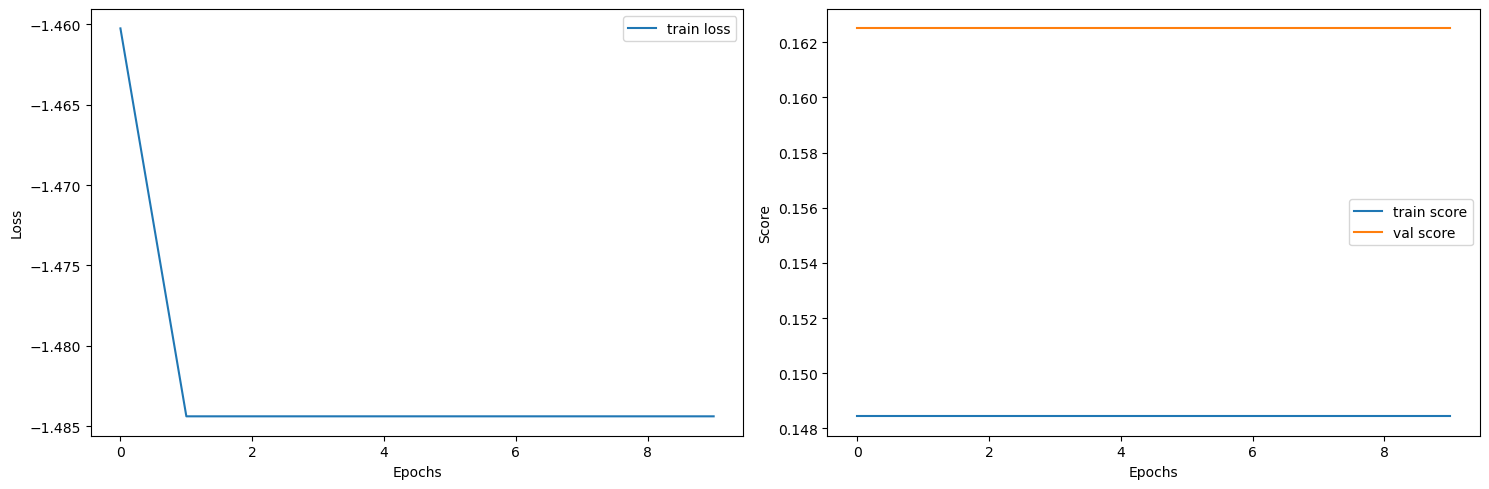

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.67s/it]


In [42]:
_ = Helper.train(modelA, optimizer, dataloaders, loss, n_epochs=10, plot=True)

In [43]:
Helper.eval_fn_dl(modelA, test_loader)

0.1375

In [44]:
with torch.no_grad():
    X, y_true = test_loader.dataset[1]
    y_pred = modelA(torch.IntTensor(X))
    print(y_pred.shape)
    print(f"True class: {cat_encoder.inverse_transform(y_true)}")
    print(f"Predicted class: {cat_encoder.inverse_transform(y_pred)}")

TypeError: len() of a 0-d tensor

In [45]:
class BahdanauAttention(nn.Module):

    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.W_a = nn.Linear(decoder_hidden_dim, decoder_hidden_dim, bias=False)
        self.U_a = nn.Linear(encoder_hidden_dim, decoder_hidden_dim, bias=False)
        self.v = nn.Linear(decoder_hidden_dim, 1, bias=False)

    @logger.trace('ATN')
    def forward(self, decoder_hidden, encoder_hidden):

        s = self.W_a(decoder_hidden).unsqueeze(1)
        h = self.U_a(encoder_hidden)
        # print(s.shape, h.shape)
        scores = self.v(F.tanh(s+h))
        attention_weights = F.softmax(scores, dim=1).squeeze(-1)
        context_vector = torch.einsum('bs,bsh->bh', attention_weights, encoder_hidden)
        return context_vector, attention_weights

class AttentionTextClassifier(nn.Module):

    def __init__(self, embeddings, hidden_size, num_classes, window_size=10, stride=2, n_layers=1, dropout=0.5, bidirectional=True):
        super().__init__()
        self.window_size = window_size
        self.encoder = Encoder(embeddings, hidden_size, n_layers, dropout, bidirectional)
        rnn_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.attention = BahdanauAttention(rnn_output_size, rnn_output_size)
        self.fc = nn.Linear(rnn_output_size, num_classes)

    def forward(self, text, text_lengths=None):
        output, _ = self.encoder(text, text_lengths)
        batch_size, seq_length, _ = output.shape
        context_vectors = []

        for i in range(0, seq_length, self.window_size):
            window = output[:, i:i + self.window_size, :]
            decoder_hidden = output[:, min(i + self.window_size - 1, seq_length - 1), :]
            context_vector, _ = self.attention(decoder_hidden, window)
            context_vectors.append(context_vector)

        context_vectors = torch.stack(context_vectors, dim=1)
        context_vector = context_vectors.mean(dim=1)
        output = self.fc(context_vector)
        return F.softmax(output, dim=1)

modelB = AttentionTextClassifier(embedding, HIDDEN_SIZE, NCLASSES, 10, 2, N_LAYERS, DROPOUT)
torchinfo.summary(modelB)


Layer (type:depth-idx)                   Param #
AttentionTextClassifier                  --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    (20,000,200)
│    └─GRU: 2-2                          30,600
│    └─Dropout: 2-3                      --
├─BahdanauAttention: 1-2                 --
│    └─Linear: 2-4                       10,000
│    └─Linear: 2-5                       10,000
│    └─Linear: 2-6                       100
├─Linear: 1-3                            1,616
Total params: 20,052,516
Trainable params: 52,316
Non-trainable params: 20,000,200

In [ ]:
# Пример входных данных
sample_text = ["this is a test recipe, very long test recipe !"]
tokenized = [tokenizer.tokenize(sample, preprocess=True) for sample in sample_text]
input_tensor = torch.tensor(tokenized, dtype=torch.long)  # (batch, seq_len)
text_lengths = torch.tensor([len(seq) for seq in tokenized], dtype=torch.long)  # (batch,)

# Вызов модели
modelB.eval()
logger.zero()
logger.clear_log()
logger.on()
with torch.no_grad():
    y_pred = modelB(input_tensor, text_lengths)
    print(y_pred)
    print(f"Predicted class: {cat_encoder.inverse_transform(y_pred)}" )
logger.off()

In [50]:
optimizer = torch.optim.Adam(modelB.parameters(), lr=3e-4)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
loss = torch.nn.CrossEntropyLoss()
Helper.eval_fn = Scores.f1_score

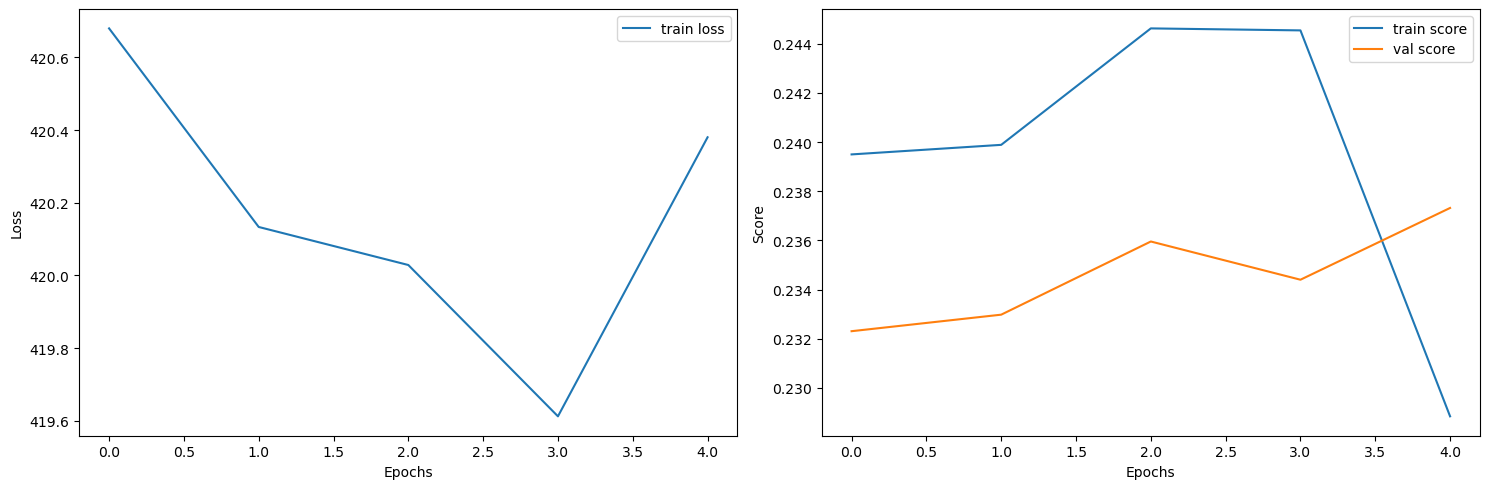

100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.11s/it]


In [51]:
_ = Helper.train(modelB, optimizer, dataloaders, loss, n_epochs=5, plot=True)